# Notebook to create content similarity based on the data in the MongoDB database

### Handle imports

In [ ]:
import os

import pandas as pd
import numpy as np
from pymongo import MongoClient
import re
import tweepy
import datetime
from matplotlib import pyplot as plt
import spacy
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
tqdm.pandas()

### Function to extract relevant users from the clusters in the textClust mongoDB database

In [4]:
def extract_relevant_users_from_clusters(source_uuid, cluster_id, timestamp):
    connection = MongoClient(f"mongodb://localhost:27017/")
    db = connection.textclustDB
    
    # Extract all tweets of a cluster from the MongoDB database
    textids = db[f"mc_{source_uuid}"].find_one(
        {"id": cluster_id},
        sort=[("timestamp", -1)],
        projection={
            "_id": 0,
            "textids": 1
            }
    )
    
    # Extract the relevant users
    users = db[f"texts_{source_uuid}"].find(
        {
            "$and": [
                {"general.text_id": {
                        "$in": textids["textids"]
                    }
                },
                {"$or": [
                    {"general.time": {
                        "$lte": datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S")
                        }
                    },
                    {"general.time": {
                        "$lte": timestamp.replace("T", " ")
                        }
                    }
                ]}
            ]
        },
        sort=[("general.time", -1)],
        projection = {
            "_id": 0,
            "user": "$specific.user"
        }
    ).limit(5000)
    users = pd.DataFrame([user['user'] for user in users])
    return users.drop_duplicates(["id_str"], ignore_index=True)


In [6]:
users = extract_relevant_users_from_clusters("8273444c-abdd-4410-829a-970846ebd00e", 52525, "2022-02-25T22:41:49")

## Approach to use the MongoDB database to acquire the tweets

### Load last tweets of the users in the cluster from the MongoDB database

In [7]:
def extract_tweets_per_user(source_uuid, user, timestamp):
    connection = MongoClient(f"mongodb://localhost:27017/")
    db = connection.textclustDB
    data =  db[f"texts_{source_uuid}"].find(
        {"$and": [
            {"specific.user.id": user['id']}, 
            {"$or": [
                    {"general.time": {
                        "$lte": datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S")
                        }
                    },
                    {"general.time": {
                        "$lte": timestamp.replace("T", " ")
                        }
                    }
                ]}
        ]},
        projection={
            "_id": 0,
            "user_screen_name": "$specific.user.screen_name",
            "user_id": "$specific.user.id_str",
            "id": "$specific.user.id",
            "text": "$general.text",
            "created_at": "$general.time"
        }
        )
    return pd.DataFrame(list(data))

### Execute the method for every user

In [9]:
tweets = pd.DataFrame(columns=["user_screen_name", "user_id", "id", "text", "created_at"])

for _, user in tqdm(users.iterrows(), total=len(users)):
    response = extract_tweets_per_user("8273444c-abdd-4410-829a-970846ebd00e", user, "2022-02-25T22:41:49")
    tweets = pd.concat([tweets, response], ignore_index=True)

  0%|          | 0/17715 [00:00<?, ?it/s]

### Filter users with too few tweets in the dataset

In [12]:
v = tweets["user_screen_name"].value_counts()
tweets = tweets[tweets["user_screen_name"].isin(v.index[v.gt(5)])]
tweets.reset_index(inplace=True, drop=True)

### Adapt timestamp types

In [14]:

tweets['created_at'] = tweets['created_at'].values.astype('datetime64[m]')
tweet = tweets.astype({'created_at': 'datetime64[m]'})

### Concatenate all tweets of a user

In [15]:
grouped_texts = tweet.groupby(["user_screen_name"]).agg({'text': ' '.join})

### Function to apply the preprocessing

The code is used from the original textClust implementation with some slight adaptions

In [16]:
import string
import emoji

def create_preprocessed_text(text):
    # Lower text
    text = text.lower()

    # Remove text wrap
    text = text.replace("\n", " ")

    # Remove URLs
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', text)
    text = re.sub(r'http\S+', '', text)

    # Remove usernames
    text = re.sub('@[^\s]+', '', text)
        
    # remove the # in #hashtag
    text = re.sub(r'#([^\s]+)', r'\1', text)

    ## remove multi exclamation mark
    text = re.sub(r"(\!)\1+", ' multiExclamation ', text)
    
    # Initialize Punctuation set
    exclude = '’“' + string.punctuation
    
    # Check char characters to see if they are in punctuation
    text = [char for char in text if char not in exclude]
    
    # Join the characters again to form the string.
    text = ''.join(text)

    # Remove emojis
    text = emoji.get_emoji_regexp().sub(r'', text)

    return text

### Create lemmatizer based on spacy

In [17]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

def spacy_tokenizer(doc):
    return [x.lemma_ for x in nlp(doc)]

### Create the TF-IDF vectors for the users

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(preprocessor=create_preprocessed_text, tokenizer=spacy_tokenizer, ngram_range=(1,2), max_features=20000)
tf_matrix = tf.fit_transform(grouped_texts['text'])

### Tranform the numpy array to a pandas dataframe

In [19]:
tf_matrix = pd.DataFrame(tf_matrix.toarray(), index=grouped_texts.index.values)
# Remove users that only have 0 vectors as they will result in a cosine similarity of NaN
tf_matrix = tf_matrix.loc[~(tf_matrix==0).all(axis=1)]

### Create similarity matrix for users with TF-IDF

This function was later adapted in the code to use tqdm so that one can see the progress in the console.

In [20]:
from scipy.spatial.distance import pdist, squareform
result = pd.DataFrame(squareform(pdist(tf_matrix, metric='cosine')), columns=tf_matrix.index.values, index=tf_matrix.index.values)

### Remove the scores on the diagonal to be zero because a user should not have a similarity to itself

In [21]:
np.fill_diagonal(result.values, 1.0)
similarity = 1 - result

### Create similarity graph

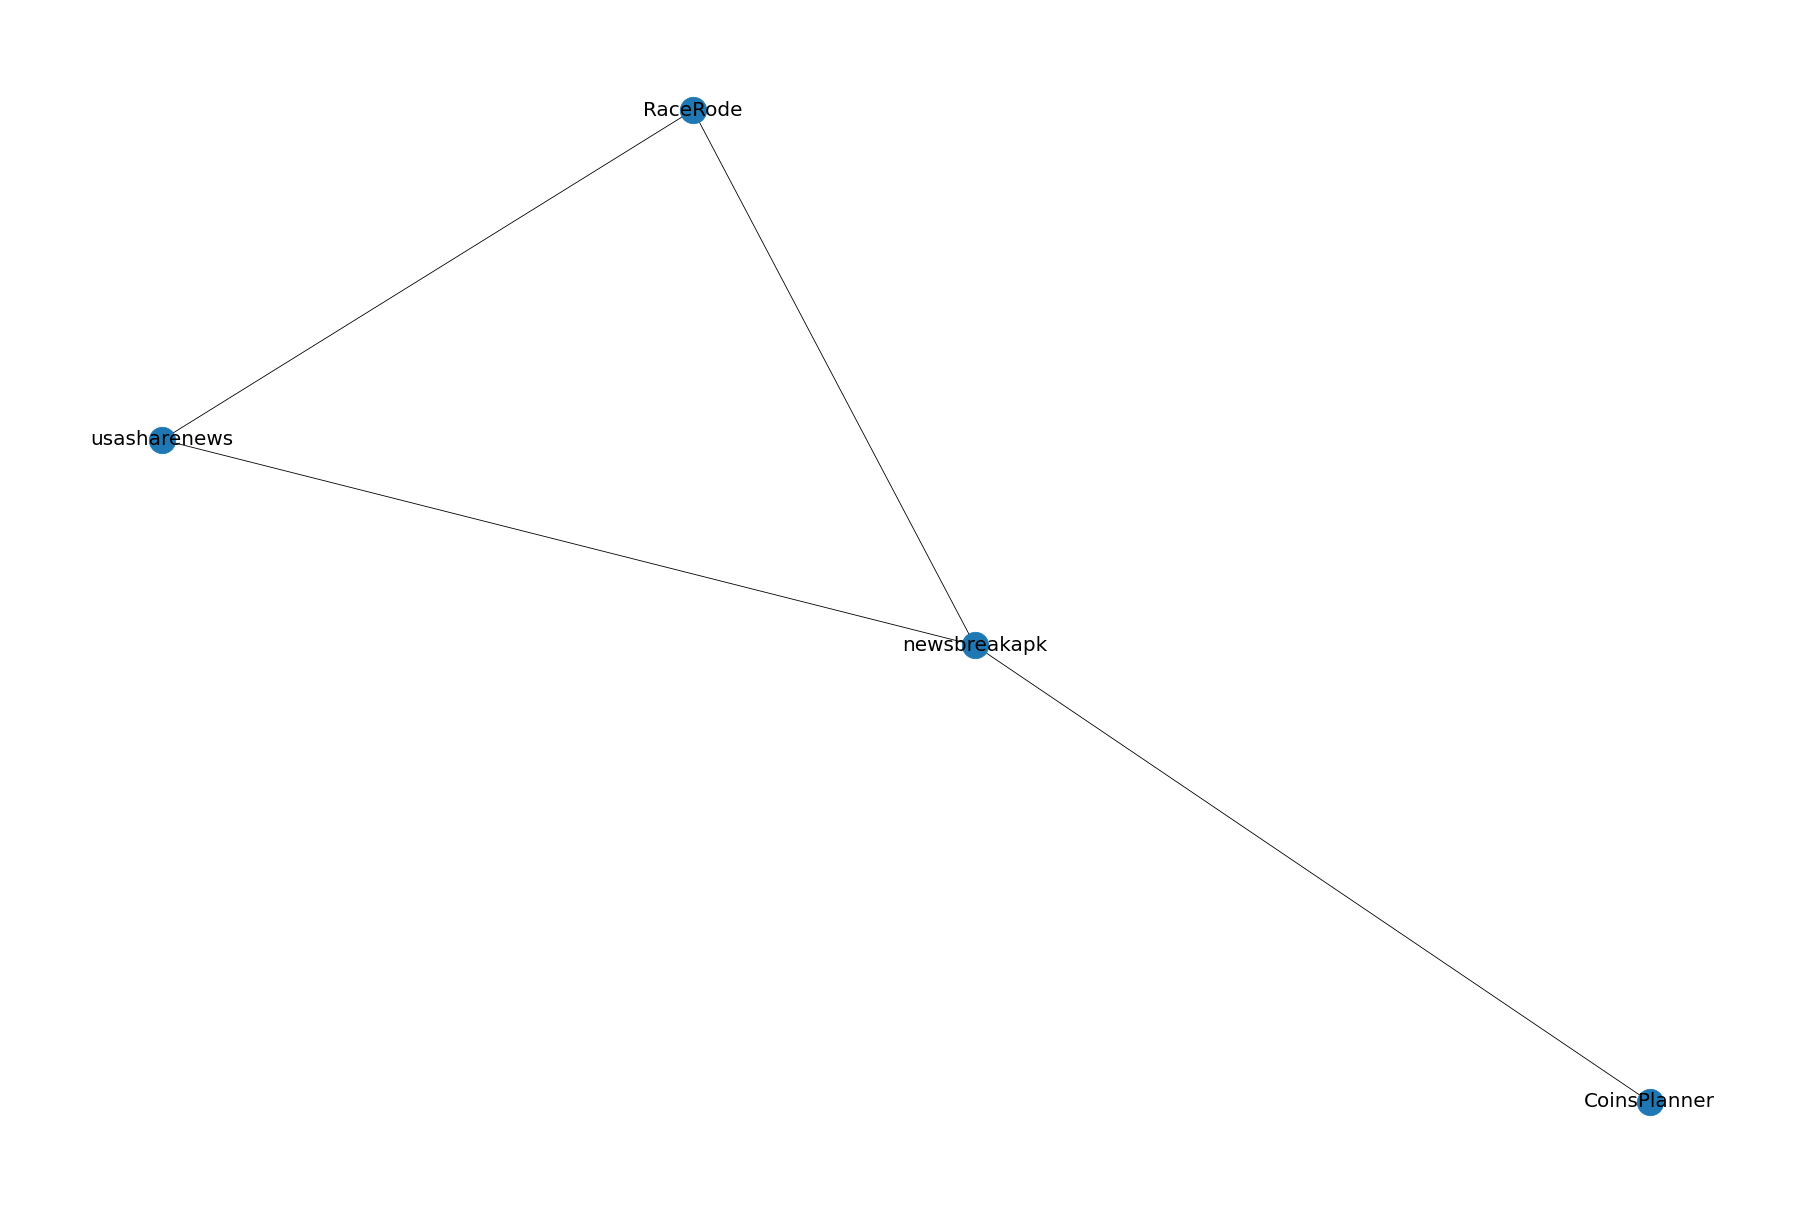

In [25]:
G = nx.from_pandas_adjacency(similarity)

F = G.copy()
# Define the filter were edges should be cut
threshold = 0.9
F.remove_edges_from([(n1, n2) for n1, n2, w in F.edges(data="weight") if w < threshold])
F.remove_nodes_from(list(nx.isolates(F)))
fig = plt.figure(1, figsize=(30, 20), dpi=60)
nx.draw(F, with_labels=True, node_size=1000, font_size=24)
plt.show()